# Generalized linear models
A generalized linear model (GLM) is a flexible generalization of ordinary linear regression.

It generalizes linear regression by allowing the linear model to be related to the response variable via an **inverse link function** $f$.
$$
    \mu = f(\alpha + X\beta)
$$

There are many inverse link function that can be used,
the simplest one is the *identity*. <br>
Others inverse link functions can be used to deal with **categorical variables** or to **restrict the output** to an interval (only positive for example)

# Linear Regression

Probabilistically, a linear regression model can be expressed as follows:

$$y \sim \mathcal{N}(\mu = \alpha + x\beta, \epsilon)$$

where $x$ denotes the input features, $y$ denotes the target feature, and $\alpha$ and $\beta$ are respectively *intercept* and *slope* of the linear relationship.
So, the targets are assumed to be distributed as a Gaussian with mean $\alpha + x\beta$ and standard deviation $\epsilon$, which controls the amount of noise in our data.

Since we do not know the values of $\alpha$, $\beta$ or $\epsilon$, we have to set prior distributions for them.
A common yet reasonable choice for such distributions are the Gaussian and the non-negative Gaussian distributions (also called Half Gaussian).

$$\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathcal{N}(0,\sigma_\epsilon)|$$


In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

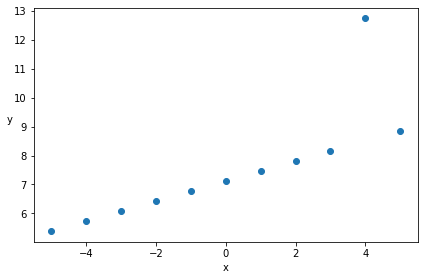

In [2]:
# Load one of the Anscombe quartet
data = pd.read_csv('data/anscombe.csv')
x = data[data.group == 'III']['x'].values
y = data[data.group == 'III']['y'].values
x -= x.mean()

# Plot the data
plt.plot(x, y, 'C0o')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.tight_layout()
plt.show()

Using PyMC3 we can build a linear regression model with almost a _one-to-one_ correspondence with the formulas showed above.
Moreover, we can easily sample from the **posterior distribution**.
In other words, we obtain the parameters values that are _consistent_ with the underlying data, of course with different amount of _likelihood_.

In [3]:
# Build a PyMC3 linear regression model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=y.mean(), sd=1.0)
    beta = pm.Normal('beta', mu=0.0, sd=1.0)
    eps = pm.HalfNormal('eps', 5.0)
    y_pred = pm.Normal('y_pred', mu=alpha + x * beta, sd=eps, observed=y)

# Sample from posterior
with model:
    trace = pm.sample(
        draws=2000, tune=1000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Using Arziv we can plot both the posterior distributions of our parameters, and also the traces given by the **Markov Chain Monte Carlo** (MCMC) procedure.

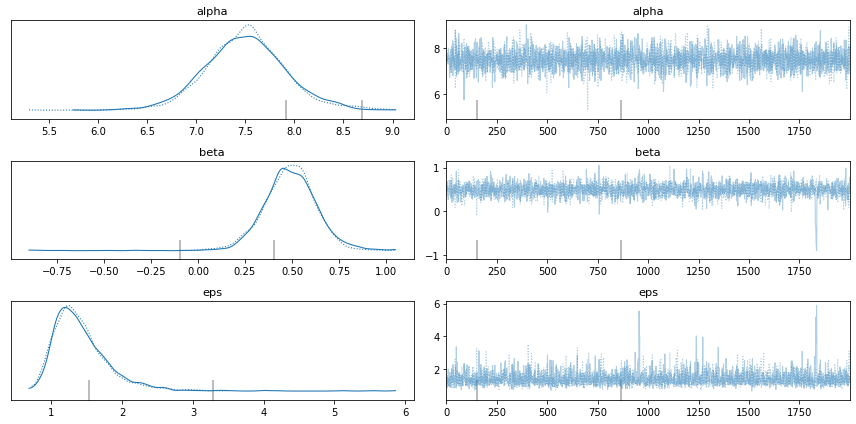

In [4]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps'])
plt.tight_layout()
plt.show()

For graphical representation purposes, we can consider the _average_ of the sampled values for $\alpha$ and $\beta$ parameters.
Moreover, for each input data point we can sample from the _conditional_ probability distribution using PyMC3.
So, in other words we can plot the target samples in the **Highest Density Interval** (HDI). 

In [5]:
# Compute average values of sampled parameters
alpha_m = trace['posterior']['alpha'].mean().item()
beta_m = trace['posterior']['beta'].mean().item()

# Sample from the conditional distributions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

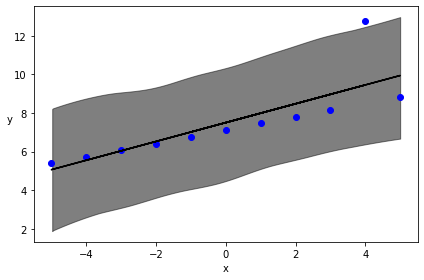

In [19]:
# Plot the HDI graph
az.plot_hdi(x, ppc['y_pred'], color='k')
plt.plot(x, y, 'o', c='b')
plt.plot(x, alpha_m + beta_m * x, c='k')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.tight_layout()
plt.show()

### Robust Linear Regression

As noted previously, the presence of outliers in our data might make our Gaussian assumption fail.
In general a Student t-distribution is a way to effectively deal with outliers and get a more robust inference.
To do so, we must define another prior distribution over the _degrees of freedom_ of the Student t-distribution (i.e. the number of values of a statistic that are free to vary).
A common choice for this prior is given by a translated Exponential distribution.
The resulting robust linear regression model is defined below.

$$\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathcal{N}(0,\sigma_\epsilon)|$$
$$\nu \sim 1 + \mathcal{E}(\lambda)$$
$$y \sim \alpha + x\beta + \epsilon\mathcal{T}(\nu)$$

In [23]:
# Build a PyMC3 linear regression model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=y.mean(), sd=1.0)
    beta = pm.Normal('beta', mu=0.0, sd=1.0)
    eps = pm.HalfNormal('eps', 5.0)
    nu = 1 + pm.Exponential('nu', 1.0 / 29.0)
    y_pred = pm.StudentT('y_pred', mu=alpha + x * beta, sd=eps, nu=nu, observed=y)

# Sample from posterior
with model:
    trace = pm.sample(
        draws=2000, tune=1000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, eps, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


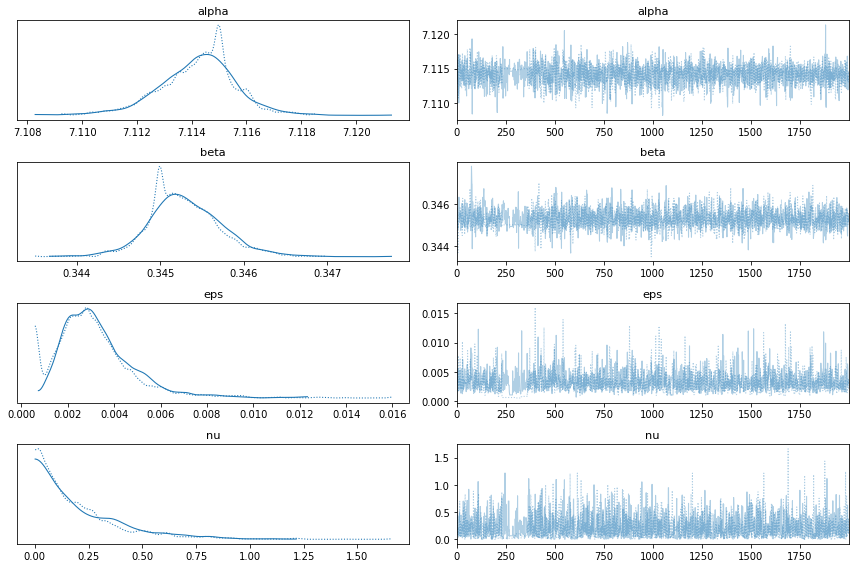

In [24]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps', 'nu'])
plt.tight_layout()
plt.show()

As we can see, the relevance of important outliers is strictly reduced.
In this case the posterior predictive distribution collapses to a single point.

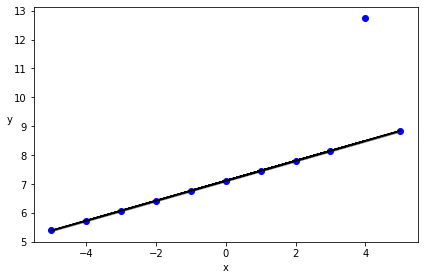

In [25]:
alpha_m = trace['posterior']['alpha'].mean().item()
beta_m = trace['posterior']['beta'].mean().item()
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)
az.plot_hdi(x, ppc['y_pred'], color='k')
plt.plot(x, y, 'o', c='b')
plt.plot(x, alpha_m + beta_m * x, c='k')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.tight_layout()
plt.show()

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Logistic Regression
The logistic regression model is a generalization of the linear regression model, and thus its name. We achieve this generalization by plcing the logistic function as an inverse link function:
$$
logistic(z) = \frac{1}{1+e^{-z}}
$$

Text(0, 0.5, 'logistic(z)')

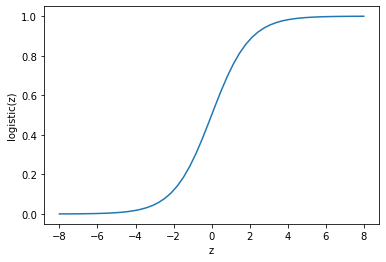

In [10]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

### The logistic model
Omitting the priors we have:
$$
\theta = logistic(\alpha + x\beta) \\
y = Bern(\theta)
$$

### The Iris Dataset
We will take in account a simple binary classification task with the IRIS dataset:
- 50 Individual cases for each species
- 4 variable for each case
- 2 classes

In [3]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Plot of the species versus Sepal Length. <br>
N.B. The jitter has no meaning, is only for better visualization

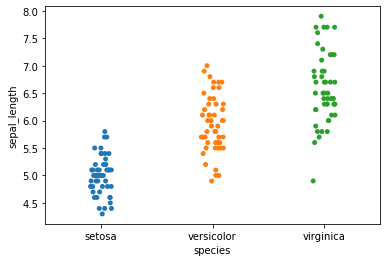

In [12]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B11197_04_02.png', dpi=300);

Scatter Matrix

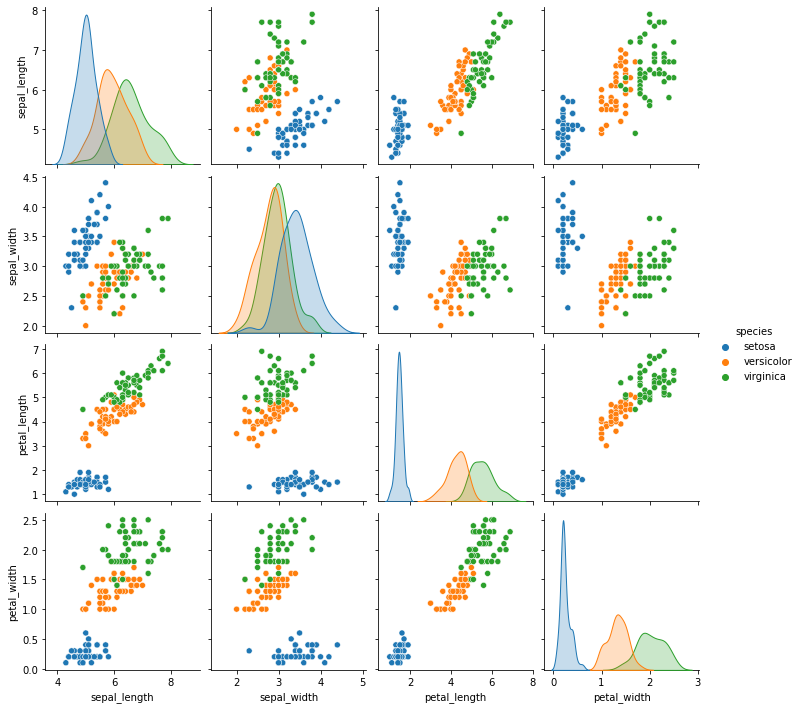

In [15]:
sns.pairplot(iris, hue='species', diag_kind='kde')

### The logistic model applied to the iris dataset
We'll simplify:
- two classes: `setosa` and `versicolor`;
- just one independent variable or feature, `the sepal_lenght`

In [8]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

Center the data to help sampling

In [19]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_c, beta)    
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu)) # Output of the logistic regression
    bd = pm.Deterministic('bd', -alpha/beta) # Boundary decision
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    trace_0 = pm.sample(1000)

C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_26096\3453774653.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_0 = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [36]:
def plot_log_reg():
    theta = trace_0['theta'].mean(axis=0)
    idx = np.argsort(x_c)
    plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
    plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
    bd_hdi = az.hdi(trace_0['bd'])
    plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

    plt.scatter(x_c, np.random.normal(y_0, 0.02),
                marker='.', color=[f'C{x}' for x in y_0])
    az.plot_hdi(x_c, trace_0['theta'], color='C2')
    plt.xlabel(x_n)
    plt.ylabel('theta', rotation=0)
    # use original scale for xticks
    locs, _ = plt.xticks()
    plt.xticks(locs, np.round(locs + x_0.mean(), 1))
    plt.show()

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


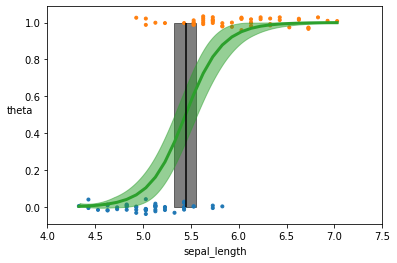

In [37]:
plot_log_reg()

The green line can be interpreted as the probability of a flower being versicolor. <br>
The boundary decision is represented as a (black) vertical line with a semi-transparent band for its 94% HDI. <br>
It is the $x$ point where $y = 0.5$

## Multiple logistic regression
In order to deal with more than one independent variable, similar to regression, we can user multiple logistic regression:

In [9]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

Using vectorization capabilities, we can implement the model with minor modification:

In [5]:
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))

    mu = alpha + pm.math.dot(x_1, beta)
    theta = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])

    yl = pm.Bernoulli('yl', p=theta, observed=y_1)

    trace_1 = pm.sample(2000)

C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_20524\3527575172.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5473975412749303, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Plot data with decision boundary:

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


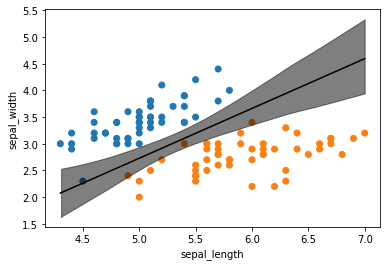

In [11]:
idx = np.argsort(x_1[:,0])
bd = trace_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0])
plt.plot(x_1[:,0][idx], bd, color='k')

az.plot_hdi(x_1[:,0], trace_1['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])
plt.show()

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#  The Poisson Distribution

Another very popular generalized linear model is the **Poisson regression**. This model assumes data is distributed according to the Poisson distribution.
One scenario where Poisson distribution is useful is when *counting* things, such as:
- the decay of a radioactive nucleus
- the number of children per couple, or the number of Twitter followers;
- etc...
Models using discrete non-negative numbers: {0, 1, 2, 3, ....}. This type of variable receives the name of **count data**.

Probability Mass function:
$$
f(x|\mu) = \frac{e^{-\mu}\mu^x}{x!}
$$
where:
- $\mu$ is the average number of eventts per unit of time/space
- $x$ is a positive integer value {0, 1, 2, ...}

## Zero-inflated Poisson model
Often, when performing posterior predictive check,
model generates fewer 0s compared to the data, how do we model?

We assume we have a mixture of two processes modeled by:
- Poisson distribution with probability $\psi$
- *extra zeros* with probability $1 - \psi$

This is the **zero-inflated distribution (ZIP)**
$$
p(y_j = 0) = 1 - \psi + (\psi)e^{-\mu} \\
p(y_j = x_i) = \psi\frac{\mu^{x_i} e^{-\mu}}{x_i!}
$$

## ZIP Regression
We use the exponential function as inverse-link function to ensure positive numbers:
$$
\theta = e^{\alpha + X\beta}
$$

### The fish dataset
- 250 group of visitors at park
    - number of fish they caught (`count`)
    - children per group (`child`)
    - brought a camper or not (`camper`)

We are going to build a model that predicts the number of fish caught

In [5]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


Let's implement the model:

C:\Users\PasqualeDeMarinis\AppData\Local\Temp\ipykernel_4608\500307600.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ZIP_reg = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, psi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The acceptance probability does not match the target. It is 0.8918131762499402, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


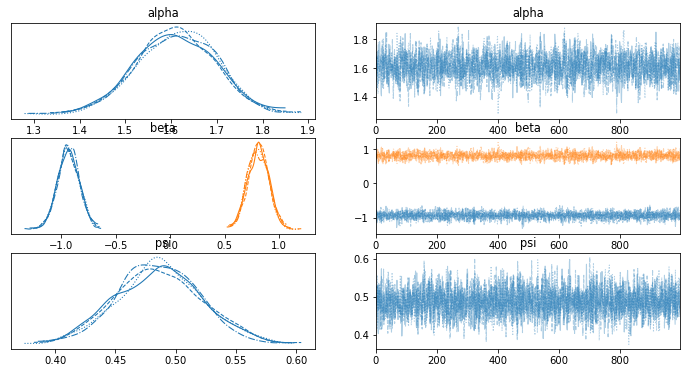

In [6]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    theta = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', psi, theta, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000)
az.plot_trace(trace_ZIP_reg);

In [10]:
def fish_plot():
    children = [0, 1, 2, 3, 4]
    fish_count_pred_0 = []
    fish_count_pred_1 = []
    for n in children:
        without_camper = trace_ZIP_reg['alpha'] + trace_ZIP_reg['beta'][:,0] * n
        with_camper = without_camper + trace_ZIP_reg['beta'][:,1]
        fish_count_pred_0.append(np.exp(without_camper))
        fish_count_pred_1.append(np.exp(with_camper))
    plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
    plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

    plt.xticks(children);
    plt.xlabel('Number of children')
    plt.ylabel('Fish caught')
    plt.plot([], 'C0o', label='without camper')
    plt.plot([], 'C1o', label='with camper')
    plt.legend()
    plt.show()  

Let's make some plot to better understand the results

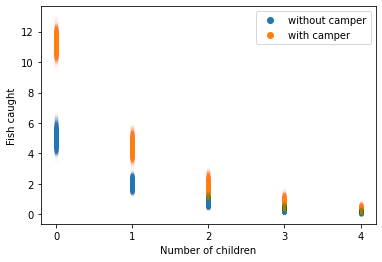

In [11]:
fish_plot()

- Expected number of fish caught decreases as children augments
- Having a camper increases the expected count of fish